In [8]:
# Standard library imports
import argparse
import math

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib import cm
import seaborn as sns
from pymol import cmd

# Local application imports
from data_processing import process_table, load_ranges_file, process_cleaned_data, get_unique_sorted, create_sequence_dict
from utils import compile_exchange_info, fit_functions
from plot_functions import assign_colors, create_plot, handle_element, handle_list_item, adjust_plot, save_plot



def load_data(args):
    newbigdf = pd.DataFrame()

    # Process all tables
    for table in args.table:
        newbigdf = pd.concat([newbigdf, process_table(table)])

    # Convert columns to the appropriate data types
    newbigdf['Start'] = newbigdf['Start'].apply(np.int64)
    newbigdf['End'] = newbigdf['End'].apply(np.int64)
    newbigdf['#D'] = newbigdf['#D'].apply(float)

    return newbigdf


def clean_data(args, newbigdf):
    cleaned  = load_ranges_file(args.ranges, newbigdf, args.exclude)
    cleaned = process_cleaned_data(cleaned)

    states = list(dict.fromkeys(cleaned['Protein State']))
    peptides = list(dict.fromkeys(cleaned['Sequence']))
    timepoints = list(dict.fromkeys(cleaned['Deut Time (sec)']))

    states_dict, first_res, peptides_2 = create_sequence_dict(cleaned, states)

    return cleaned, states, peptides, timepoints, states_dict, first_res, peptides_2


def fit_data(cleaned, states, states_dict, peptides, timepoints):
    # Compile the exchange information
    peptide_exchange_dict, stdev_dict_dict = compile_exchange_info(cleaned, states, states_dict)

    # Fit the exchange functions
    trialT, peptide_fit_dict, peptide_params_dict, peptide_err_dict = fit_functions(peptides, peptide_exchange_dict, timepoints)

    return peptide_exchange_dict, stdev_dict_dict, trialT, peptide_fit_dict, peptide_params_dict, peptide_err_dict


def plot_uptake_plots(peptide_exchange_dict, timepoints, stdev_dict_dict, color_dict, peptide_fit_dict, ax1, trialT, peptides_2):
    for peptide in peptide_exchange_dict:
        element = peptide_exchange_dict.get(peptide)
        if element is not None:
            handle_element(peptide, element, timepoints, stdev_dict_dict, color_dict, peptide_fit_dict, ax1, trialT)
            for list_item in peptides_2:
                plot_title, y_lim = handle_list_item(list_item, peptide, ax1, peptides_2)
                if plot_title and y_lim is not None:
                    adjust_plot(ax1, plot_title, y_lim)
                    save_plot(plot_title)
            ax1.clear()

    plt.close('all')




In [9]:
# Create a function to generate pairs
def generate_pairs(states, args):
    pairs = []
    if len(states) > 1:
        for state1 in states:
            for state2 in states:
                if [state2, state1] not in pairs and state1 != state2:
                    pairs.append([state1, state2])
        if (args.s1 is not None) and (args.s2 is not None):
            pairs.append([args.s1, args.s2])
    return pairs

# Create a function to calculate differential expressions
def calculate_differential(pairs, peptide_exchange_dict, peptides_2, timepoints):
    dDt_tps_dict_dict = {}
    dDS_dict_dict = {}
    dDbar_dict_dict = {}

    for pair in pairs:
        dDt_tps_dict, dDS_dict, dDbar_dict = {}, {}, {}

        for peptide in peptide_exchange_dict:
            dDt_tps = [np.array(peptide_exchange_dict.get(peptide).get(key)) for key in peptide_exchange_dict.get(peptide) if key in pair]

            if dDt_tps[0].size == dDt_tps[1].size:
                dDS = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
                n_T = len(dDS)
                dDS_dict[peptide] = [np.nansum(dDS)]
                dDbar_dict[peptide] = [np.nansum(dDS)/n_T]
                dDt_tps = (dDt_tps[0] - dDt_tps[1])/(len(peptide) - 2 - peptide[2:].count('P'))
                dDt_tps_dict[peptide] = dDt_tps

        # save dict for each pair
        dDt_tps_dict_dict[tuple(pair)] = dDt_tps_dict
        dDS_dict_dict[tuple(pair)] = dDS_dict
        dDbar_dict_dict[tuple(pair)] = dDbar_dict

        # Generating lists for heatmap
        #heatmap_timepoints, heatmap_peptides, heatmap_values = generate_heatmap_lists(peptides_2, timepoints, dDt_tps_dict)

        # Create a heatmap
        #heatmap_df = create_heatmap(heatmap_timepoints, heatmap_peptides, heatmap_values, pair)

        # TODO: Continue splitting into functions
        ...

    return  dDt_tps_dict_dict, dDS_dict_dict, dDbar_dict_dict, 

# Create a function to generate heatmap lists
def generate_heatmap_lists(peptides_2, timepoints, dDt_tps_dict):
    heatmap_timepoints = timepoints * len(peptides_2)
    heatmap_peptides = []
    heatmap_values = []

    for peptide in peptides_2:
        temp_peptides = [peptide]*len(timepoints)
        heatmap_peptides.append(temp_peptides)
        if peptide.split()[1] in dDt_tps_dict.keys():
            heatmap_values = heatmap_values + (list(dDt_tps_dict[peptide.split()[1]][:,0]))

    flat_list = [item for sublist in heatmap_peptides for item in sublist]

    return heatmap_timepoints, flat_list, heatmap_values

import seaborn as sns




In [12]:
import matplotlib.colors as col
from matplotlib.patches import Rectangle
from matplotlib import cm
import pandas as pd

def process_pair(pair, reps_dict_list, stdev_dict_dict, dDbar_dict_dict, colorbar_max, colormap, peptides_2):
    dicts = get_dicts(pair, stdev_dict_dict)
    process_dicts(*dicts.values(), reps_dict_list, pair)
    dDbar_heatmap_df = process_dDbar_df(pair, peptides_2, dDbar_dict_dict)
    dDbar_heatmap_df.to_csv(f'plots/peptide_df_{pair[0]}_{pair[1]}')
    create_heatmap(dDbar_heatmap_df, pair, colorbar_max)
    save_residue_array(dDbar_heatmap_df, pair)
    generate_and_save_plots(pair, dDbar_heatmap_df, colorbar_max, colormap)


def generate_and_save_plots(pair, dDbar_heatmap_df, colorbar_max, colormap):
    df = dDbar_heatmap_df
    df.to_csv(f'plots/{"-".join(pair)}-heatmapdf.csv')

    rgb_df = process_df(df, colorbar_max, colormap)
    sorted_rgb_df = sort_df(rgb_df)
    color_cmd(sorted_rgb_df)
    cmd.save(f'plots/{"-".join(pair)}-pm.pse')

    save_df_plot(df, colormap, colorbar_max)


def process_df(df, top, colormap):
    s = df['Sensitivity'].copy()
    s = (s + top) / (2 * top)
    s.clip(upper=1, lower=0, inplace=True)
    rgb = colormap(s)*255
    new_df = pd.DataFrame({
        'Sequence': df['Sequence'],
        'r': rgb[:,0],
        'g': rgb[:,1],
        'b': rgb[:,2],
    })
    return new_df


def sort_df(df):
    df.sort_values(by='Sequence', key=lambda ser: [len(s.split()[1]) for s in ser], ascending=False, inplace=True)
    df.reset_index(inplace=True)
    return df


def color_cmd(rgb):
    cmd.color("gray")
    for i, seq in enumerate(rgb['Sequence']):
        seq = seq.split()[-1]
        cmd.select(seq, 'pepseq ' + seq)
        cmd.set_color(seq, [rgb['r'][i], rgb['g'][i], rgb['b'][i]])
        cmd.color(seq, seq)
    cmd.ray(1000,1000)


def save_df_plot(df, colormap, colorbar_max):
    df.sort_values(by=['Start','End'], inplace=True)
    fig, ax = plt.subplots(figsize=(20,10))
    leftbound = df['Start'][0]-10
    rightbound = max(df['End'])+10
    ax.set_xlim(leftbound,rightbound)
    ax.xaxis.set_ticks(np.arange(round(leftbound,-1), round(rightbound,-1), 10))
    ax.set_ylim(-5,110)
    ax.grid(axis='x')
    ax.yaxis.set_ticks([])
    norm = col.Normalize(vmin=-colorbar_max,vmax=colorbar_max)
    for i in range(len(df['Start'])):
        ax.add_patch(Rectangle((df['Start'][i], (i%20)*5 + ((i//20)%2)*2.5), df['End'][i]-df['Start'][i],4, fc=colormap(norm(df['Sensitivity'][i]))))
    fig.colorbar(cm.ScalarMappable(cmap=colormap, norm=norm))
    #plt.close()



def reps_df_generation(reps_df, states):
    new_reps_df = pd.DataFrame()
    for sequence in set(reps_df['Sequence']):
        new_row = [sequence]
        for state in states:
            reps_sum = reps_df.loc[(reps_df['Sequence']==sequence) & (reps_df['Protein State']==state)]['#Rep'].sum()
            new_row.append(reps_sum)
        new_reps_df = pd.concat([new_reps_df, pd.DataFrame([new_row], columns=['Sequence']+states)])
    return new_reps_df.to_dict('records')


def get_dicts(pair, stdev_dict_dict):
    return {key: stdev_dict_dict[key] for key in stdev_dict_dict.keys() if key in pair}


def process_dicts(dict1, dict2, reps_dict_list, pair):
    u_dHXt = []
    for (k, v), (_, v2) in zip(dict1.items(), dict2.items()):
        squared_mA, squared_mB = [number ** 2 for number in v], [number ** 2 for number in v2]
        n_mA, n_mB = [el[p] for el in reps_dict_list if el["Sequence"] == k for p in pair]
        u_dDt = [math.sqrt( (a/n_mA) + (b/n_mB) ) for a, b in zip(squared_mA, squared_mB)]
        max_protons = len(k) - 2 - k[2:].count('P')
        u_dHXt.extend([ (el**2)/max_protons for el in u_dDt])
    return u_dHXt



def process_dDbar_df(pair, peptides_2, dDbar_dict_dict):
    dDbar_dict = dDbar_dict_dict.get(tuple(pair))
    return pd.DataFrame({
        'dDbar': 'dDbar', 'Sequence': peptides_2,
        'Sensitivity': [dDbar_dict[peptide.split()[1]][0] for peptide in peptides_2],
        'seq': [peptide.split(' ')[1] for peptide in peptides_2],
        'Start': [int(float(peptide.split('-')[0])) for peptide in peptides_2],
        'End': [int(float(peptide.split('-')[1])) for peptide in peptides_2]
    })

def create_heatmap(dDbar_heatmap_df, pair, colorbar_max, ):
    dDbar_df_wide = dDbar_heatmap_df.pivot_table(index='Sequence', columns='dDbar', values='Sensitivity')
    dDbar_df_wide.index = pd.CategoricalIndex(dDbar_df_wide.index, categories=peptides_2)
    dDbar_df_wide.sort_index(level=0, inplace=True)
    fig = plt.figure()
    p2 = sns.heatmap(dDbar_df_wide, cmap="RdBu", linewidths=1, vmin=-colorbar_max, vmax=colorbar_max)
    p2.set_title(pair[0] + '-\n' + pair[1])
    plt.close()

def save_residue_array(dDbar_heatmap_df, pair):
    fullseq = cmd.get_fastastr('all').split('>')[1]
    fullseq = ''.join(fullseq.split('\n')[1:])
    residue_array = np.full(len(fullseq), np.nan)
    sorted_heatmap_df = dDbar_heatmap_df.sort_values(by='seq', key=lambda ser: [len(s) for s in ser], ascending=False)
    for i in range(len(sorted_heatmap_df['seq'])):
        residue_array[sorted_heatmap_df['Start'][i]:sorted_heatmap_df['End'][i]] = sorted_heatmap_df['Sensitivity'][i]
    np.savetxt(f'plots/dD_res_level_{pair[0]}_{pair[1]}.csv', residue_array, delimiter=',')


def parse_args():
    parser = argparse.ArgumentParser(description='Statistical analysis of HDX/MS data for curated RbsR peptides in one or more functional states.')
    parser.add_argument('--pm', dest='pm', help="path to pymol structure", required=True)
    parser.add_argument('--t', '--table', dest='table', help="path to uptake table", nargs='+', required=True)
    parser.add_argument('--r', '--ranges', dest='ranges', help='path to ranges list csv')
    parser.add_argument('--e', '--exclude', dest='exclude', action='store_true', help='exclude rather than include rangeslist')
    parser.add_argument('--s1', dest='s1', help='first state to compare')
    parser.add_argument('--s2', dest='s2', help='second state to compare')
    parser.add_argument('--compare', dest='compare', help='dna, ligand, both', nargs=3)
    parser.add_argument('--cbarmax', dest='cbarmax', type=float, help='max value for colorbar axis for dDbar')
    parser.add_argument('--ldmin', dest='ldmin', type=float, help='in dDbar, minimum difference threshold between ligand/dna states')

    args = parser.parse_args(args=['--t', './example/10-25_rbsb_pool_results-CLEANED.csv',
                                   '--r', './example/rangeslist-10-25.csv', 
                                   '--pm', './example/2dri_protein.pdb',
                                   '--ldmin','0.3'])

    print(args)
    cmd.load(args.pm)
    colorbar_max = 0.2 if args.cbarmax is None else args.cbarmax
    delta_LD_threshold = 0.075 if args.ldmin is None else args.ldmin

    return args, colorbar_max, delta_LD_threshold



def main():
    args, colorbar_max, delta_LD_threshold = parse_args()
    newbigdf = load_data(args)

    global peptides_2
    cleaned, states, peptides, timepoints, states_dict, first_res, peptides_2 = clean_data(args, newbigdf)

    peptide_exchange_dict, stdev_dict_dict, trialT, peptide_fit_dict, peptide_params_dict, peptide_err_dict = fit_data(cleaned, states, states_dict, peptides, timepoints)
    

    color_dict = assign_colors(states)
    ax1 = create_plot()
    plot_uptake_plots(peptide_exchange_dict, timepoints, stdev_dict_dict, color_dict, peptide_fit_dict, ax1, trialT, peptides_2)

    
    pairs = generate_pairs(states, args)
    dDt_tps_dict_dict, dDS_dict_dict, dDbar_dict_dict = calculate_differential(pairs, peptide_exchange_dict, peptides_2, timepoints)
    reps_df = cleaned[['#Rep', 'Sequence', 'Protein State']]
    reps_dict_list = reps_df_generation(reps_df, states)

    colormap = plt.get_cmap("RdBu")
    for pair in pairs:
        process_pair(pair, reps_dict_list, stdev_dict_dict, dDbar_dict_dict, colorbar_max, colormap, peptides_2)


Namespace(cbarmax=None, compare=None, exclude=False, ldmin=0.3, pm='./example/2dri_protein.pdb', ranges='./example/rangeslist-10-25.csv', s1=None, s2=None, table=['./example/10-25_rbsb_pool_results-CLEANED.csv'])
rangeslist included !


/Users/chenlin/opt/anaconda3/envs/openmm/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/jj/7d28rm8x3_1frkhmtn_0_3yc0000gn/T/ipykernel_79563/4095881612.py:71: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(cmap=colormap, norm=norm))


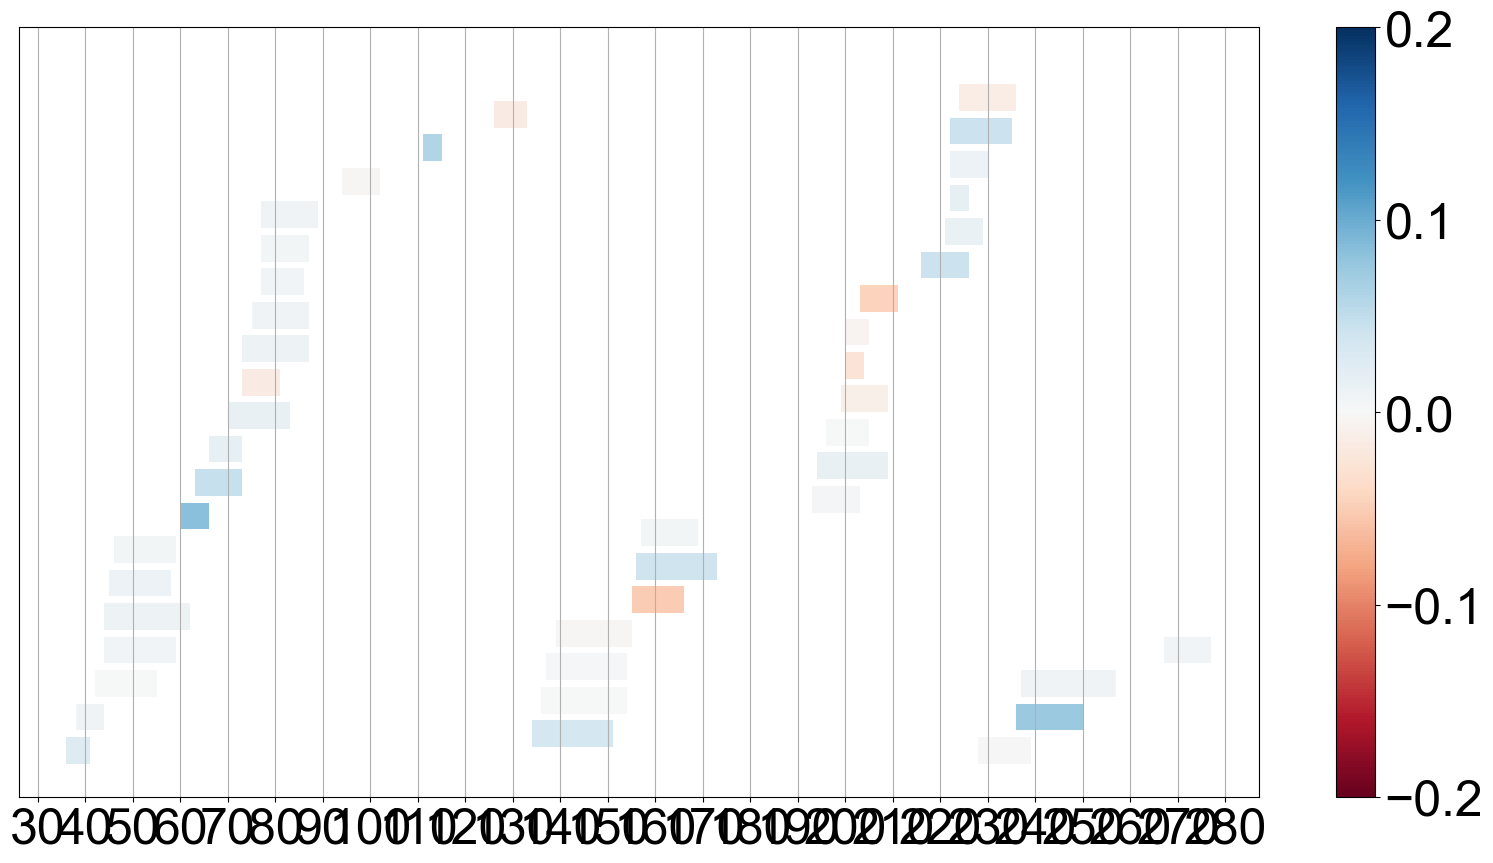

In [13]:
main()